In [1]:

import numpy as np
import pprint
import math
import matplotlib
import matplotlib.pyplot as plt
from glob import glob
import re
from re import split

This notebook covers the runs with three polystyrene (DVB-crosslinked) particles and one polyethylene particle. 

Let's set some variables:

In [2]:
mlen = 2 # number states to transition to/from
tlen = 3 # number of ways to measure transition time 
            #-> Either by length of time stable, length of time spent transitioning, or both combined

excludedvids=[] # videos which, due to errors in data collection, should not be used

sttr = '\[*list' # the correct separator for the text as it's formatted currently

And define some functions:

In [32]:
# get min, max of an array
def minmax(arr):
    return (np.min(arr), np.max(arr))

# Plot the graphs 
def plotter(xs, yls, cols, xlabel): 
    fig,ax = plt.subplots()  
    ranges = []
    for index, y in enumerate(yls):
        plt.plot(xs, y, c = cols[index], ls = '-')
        ran = minmax(y)
        plt.axhline(y=ran[0], c = cols[index], ls = ':')
        plt.axhline(y=ran[1], c = cols[index], ls = ':')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel('observed probability of transition', fontsize=16)

# Plot the graphs 
def eig_plotter(xs, yls, cols, xlabel, rangeys): 
    fig,ax = plt.subplots()  
    ranges = []
    for index, y in enumerate(yls):
        plt.plot(xs, y, c = cols[index], ls = '-')
        ran = minmax(rangeys[index])
        plt.axhline(y=ran[0], c = cols[index], ls = ':')
        plt.axhline(y=ran[1], c = cols[index], ls = ':')
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel('observed probability of transition', fontsize=16)


# Euclidean distance between two vectors
def vector_dist(v1, v2): # euclidean distance between 2 points
    return math.sqrt(np.sum([(v1[i] - v2[i])**2 for i in range(len(v1))]))

# Divide a row through by its sum
# Used for normalising rows in matrices, which might sum to zero (have no transitions)
def ratio(row):
    sums = np.sum(row)
    if sums > 0:
        return row/sums
    else:
        return row

# Divide all columns through by their sums
def col_norm(array):
    cols = array.T
    cols = np.array([ratio(j)*100 for j in cols])
    return cols.T

# Divide all rows through by their sums
def row_norm(array):
    rows = np.array([ratio(j)*100 for j in array])
    return rows

# Flatten an array of lists 
def flattener(array_of_lists):
    return(np.array([x for y in array_of_lists for x in y]))

#read data from its text file
def parser_arr(filename): 
    # returns arrays of all transitions, transition times, and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    statecounts = []
    with open(filename) as textfile:
        line = textfile.readline()
        while line:
            if 'Processing' in line: # collect the video number from the text
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                vidnum = int(vidnum)
                line = textfile.readline()
                
            #collect transition and stability thresholds
            if 'T threshold'in line:                 
                thresh_set = []
                
                # colect stability threshold
                for word in line.split():
                    try:
                        thresh_set.append(float(word))
                    except ValueError:
                        pass
                    
                # colect stability threshold
                line = textfile.readline()
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word)) 
                        except ValueError:
                            pass
                                          
                    #Initialise results arrays for this run
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        thresholds.append(thresh_set)
                        vidarrs.append([[] for i in range(3)]) # one list each for transitions, video num, and times
                        statecounts.append([]) # num recorded frames in each state
                    else:
                        pass    
                    
                    # Collect transition data
                    line = textfile.readline()
                    trarr = read_square_arr(line, textfile)
                    vidarrs[-1][0].append(trarr)
                    vidarrs[-1][1].append(vidnum)
        
                    # Collect time data
                    tiarrs = []
                    for i in range(tlen):
                        line = textfile.readline()
                        tiarr = read_square_arr_list(line, textfile) 
                        tiarrs.append(tiarr)
                        line = textfile.readline()
                    vidarrs[-1][2].append(tiarrs)  
                    
                    # Collect state data 
                    statecounts[-1].append([float(f) for f in filter(int_from_text, split(' |\[|]', line))])
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
                    
                
            
    textfile.close()
    return([np.array(thresholds), np.array(vidarrs), statecounts]) 

# Decide if text can be converted to floats
def int_from_text(text):
    try:
        float(text)
        return True
    except:
        return False
    
# Generate an integer given a simple text string
def int_from_text_list(textlist):
    elements = []
    for el in textlist:
        nums = [int(s) for s in  re.findall(r'\d+',el)]
        elements.append(nums)
    return elements

# Read one of the transition arrays
def read_square_arr(line, textfile):
    if '[[' in line:
        arr = np.zeros((mlen,mlen))
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        arr[0,:] = linenums

        line = textfile.readline()        
        linenums = [float(f) for f in filter(int_from_text, split(' |\[|]', line))]
        arr[1,:] = linenums

        return(arr)
    else:
        print("missing trans array") # just a warning, in case things go south
  
        
# continue reading lines until endstring is reached
def grab_full_lines(line, string, textfile):
    while string not in line: # means the row has not yet terminated so add the next line 
            line2 = textfile.readline()
            line += line2    
    return line

#Read one of the times-to-transition arrays
def read_square_arr_list(line, textfile):
    if '[[' in line:  # first line of the array
        arr =[]
        
        line = grab_full_lines(line, ')]', textfile)             
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)] #Take out newlines, split at separator, keep only non-whitespace
        linenums = int_from_text_list(prelims)
        arr.append(linenums)

        line = textfile.readline() # next row of array
        
        line = grab_full_lines(line, ')]', textfile)        
        prelims = [x for x in split(sttr , line.replace('\n', '')) if re.match('\S', x)]
        linenums = int_from_text_list(prelims)
        arr.append(linenums)

        return(np.array(arr))
    else:
        print("missing times array")


Legacy code for including old results

In [4]:

def parser_arr_old(filename):
    # returns array of all traansitions and list of all class and transition thresholds
    transitions = []
    thresholds = []
    vidarrs = []
    with open(filename) as textfile:
        line = textfile.readline()
        while line:
            if 'Processing' in line:
                vidnum = line.split('pp_')[-1]
                vidnum = vidnum.split('.avi')[0]
                vidnum = vidnum.split('_')[0]
                vidnum = int(vidnum)
                line = textfile.readline()
            if 'T threshold'in line:
                thresh_set = []
                for word in line.split():
                    try:
                        thresh_set.append(float(word))
                    except ValueError:
                        pass
                    
                line = textfile.readline()
                if 'C threshold' in line:
                    for word in line.split():
                        try:
                            thresh_set.append(float(word))
                        except ValueError:
                            pass
                                        
                    if len(thresholds) ==0 or thresholds[-1] != thresh_set:
                        thresholds.append(thresh_set)
                        vidnums=[]
                        vidarrs.append([[], vidnums])
                    else:
                        pass    
                    
                    line = textfile.readline()
                    if '[[' in line:
                        arr = np.zeros((mlen,mlen))
                        linenums = [int(s) for s in  re.findall(r'\d+',line)]
                        arr[0,:] = linenums

                        line = textfile.readline()  

                        linenums = [int(s) for s in  re.findall(r'\d+',line)]
                        arr[1,:] = linenums

                        vidarrs[-1][0].append(arr)
                        vidarrs[-1][1].append(vidnum)
                    else:
                        print("missing array")
                else:
                    print("missing C thresh")
                
                
                    
            line = textfile.readline()
                    
                
            
    textfile.close()
    return([np.array(thresholds), vidarrs]) 

Set the colors for the output plots -> first color is for Top state, second is for c-shape.

In [5]:
cols = [ 'red', 'orange' ] #Top, C-state

Now to read in some data and check that everything works. This is the newerstyrene data.

In [6]:
trans_runs= parser_arr(glob('./wash*styrene.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs]) # should be the same length = the number of runs
test = trans_runs[1][0] # video array for the first run - all videos included
pprint.pprint(test[0]) # video array for the first run - all videos included


[3, 3, 3]
[array([[ 0.,  2.],
       [ 2., 10.]]),
 array([[ 3.,  0.],
       [ 1., 81.]]),
 array([[ 1.,  1.],
       [ 2., 20.]]),
 array([[ 0.,  0.],
       [ 0., 30.]]),
 array([[10.,  8.],
       [ 8., 16.]]),
 array([[ 1.,  3.],
       [ 3., 14.]]),
 array([[ 5.,  8.],
       [ 8., 27.]]),
 array([[3., 3.],
       [3., 5.]]),
 array([[0., 0.],
       [0., 7.]]),
 array([[0., 0.],
       [0., 6.]])]


This is the old styrene data, which was thought to be glass data.

In [7]:
trans_runs_old= parser_arr_old(glob('./output wash*trans.txt')[0]) # the output file with washed styrene information
print([len(i) for i in trans_runs_old]) # should be the same length = the number of runs
test = trans_runs_old[1][0] # video array for the first run - all videos included
pprint.pprint(test[0]) # the list of transitions matrices for each video in the run



[8, 8]
[array([[2., 2.],
       [2., 3.]]),
 array([[ 6.,  1.],
       [ 0., 28.]]),
 array([[2., 2.],
       [1., 3.]]),
 array([[0., 1.],
       [1., 1.]]),
 array([[1., 2.],
       [2., 4.]]),
 array([[  2.,   4.],
       [  4., 137.]]),
 array([[ 2.,  2.],
       [ 3., 34.]]),
 array([[ 0.,  0.],
       [ 0., 10.]]),
 array([[0., 1.],
       [1., 7.]]),
 array([[0., 0.],
       [0., 4.]]),
 array([[ 0.,  0.],
       [ 0., 13.]]),
 array([[ 3.,  9.],
       [10., 24.]])]


Gettig the actual observed transitions (and times) into matrices.

In [8]:
expt_list = [trans_runs, trans_runs_old]
exptnames = ["Second Styrene Experiment", "First \"glass\" Experiment"]
vidstoexclude = [excludedvids, excludedvids]
criteria = []  # unclear what value this is
stored_y_values = {} # the transition matrices, by 
times = {}
c_threshes = {exptname: [] for exptname in exptnames} 
t_threshes = {exptname: [] for exptname in exptnames} 

for expt, exptname, excludedvids in zip(expt_list, exptnames, vidstoexclude):   
    print(exptname)
    y_vals = {}
    t_vals = {}
    run_indices = list(range(len(expt[0]))) # for all the videos in trans_runs
    for runindex in run_indices:
        trans_threshes = expt[0][runindex]
        t_threshes[exptname].append(trans_threshes[0])
        c_threshes[exptname].append(trans_threshes[1])
        criteria.append(str(int(trans_threshes[0]))+','+str(int(trans_threshes[1])))

        vidarrs = np.array(expt[1][runindex][0]) 
        if len(expt[1][runindex]) > 1:
            timarrs = np.array(expt[1][runindex][1]) 
        else:
            timarrs = []
        vidnums = expt[1][runindex][1]
        print("Run number {}, thresholds {}".format(runindex, criteria[-1]))
        print('videos recorded', vidnums)

        allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids] # index of good videos in vidnums list
        vidnums = [vidnums[x] for x in allowed_inds]
        vidarrs = vidarrs[allowed_inds]   # Choosing arrays in vidarrs corresponding to correct videos from vidnums
        print('videos used in calculations', vidnums)

        if len(vidarrs) == len(vidnums):
            vidindices = list(range(len(vidarrs))) # need to iterate over every video that's good
        else:
            print("Something's wrong with the indexing!")

        # collect list of probability transitions; one per video    
        percent_pairs = {}
        transarrlists = {}
        for vidind in vidindices: 
            T_obb = vidarrs[vidind] # observed transition matrix for this video
            if timarrs != []:
                Ti_obb = timarrs[vidindex]
            T_obb_norm = np.vstack([ratio(T_obb[i]) for i in range(len(T_obb))]) # normailise each row s othe transitions sm to 1
            counts =  ratio(np.sum(T_obb_norm, axis=0))*100 # convert to percentages
            print('Matrix observed for video {}: '.format(vidind))
            print(T_obb, '\nPrecentages:', counts)
            percent_pairs[vidind] = counts
            transarrlists[vidind] = Ti_obb
        y_vals[runindex]= percent_pairs
        t_vals[runindex] = transarrlists
        print('\nTotal transitions: ',np.sum(vidarrs), "\n Sum of all transition matrices:\n", np.sum(vidarrs, axis=0), '\n\n') 
    stored_y_values[exptname] = y_vals
    times[exptname] = t_vals
#stored_y_values = np.array(stored_y_values)

    

Second Styrene Experiment
Run number 0, thresholds 30,20
videos recorded [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
videos used in calculations [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Matrix observed for video 0: 
[[ 0.  2.]
 [ 2. 10.]] 
Precentages: [ 8.33333333 91.66666667]
Matrix observed for video 1: 
[[ 3.  0.]
 [ 1. 81.]] 
Precentages: [50.6097561 49.3902439]
Matrix observed for video 2: 
[[ 1.  1.]
 [ 2. 20.]] 
Precentages: [29.54545455 70.45454545]
Matrix observed for video 3: 
[[ 0.  0.]
 [ 0. 30.]] 
Precentages: [  0. 100.]
Matrix observed for video 4: 
[[10.  8.]
 [ 8. 16.]] 
Precentages: [44.44444444 55.55555556]
Matrix observed for video 5: 
[[ 1.  3.]
 [ 3. 14.]] 
Precentages: [21.32352941 78.67647059]
Matrix observed for video 6: 
[[ 5.  8.]
 [ 8. 27.]] 
Precentages: [30.65934066 69.34065934]
Matrix observed for video 7: 
[[3. 3.]
 [3. 5.]] 
Precentages: [43.75 56.25]
Matrix observed for video 8: 
[[0. 0.]
 [0. 7.]] 
Precentages: [  0. 100.]
Matrix observed for video 9: 
[[0. 0.]
 [0. 6.]] 


Combining the data from the two different experiments to get observed probabilities by video. 

In [9]:
exptnum = 0 # to to separate the labeling for the runs
bignum = 100 # to separate the labeling for the runs
vidprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt] # 3 dicts, one per run
    for runnum, rundict in exptdicts.items():
        keys = rundict.keys() # vifdeo number of run
        for key in keys: # a video number
            vidnumkey = exptnum + key
            if vidnumkey not in vidprops.keys():
                vidprops[vidnumkey] = rundict[key]                
            else:
                vidprops[vidnumkey] = np.vstack((vidprops[vidnumkey], rundict[key]))
    exptnum = exptnum + bignum

#Got to double check!
keys = vidprops.keys()
vidsums = [] #sum all the probabilities 
for key in keys:
    allprobs = vidprops[key]
    print("Collected all arrays for video  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    vidsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
vidsums = np.array(vidsums)
vidinds = list(range(len(keys)))    
print("\nShape of total data array", np.shape(vidsums))
    

Collected all arrays for video  0: 
[[ 8.33333333 91.66666667]
 [14.28571429 85.71428571]
 [14.28571429 85.71428571]]
And summed and averaged all probabilities:
[12.3015873 87.6984127]

Collected all arrays for video  1: 
[[50.6097561  49.3902439 ]
 [52.17391304 47.82608696]
 [52.08333333 47.91666667]]
And summed and averaged all probabilities:
[51.62233416 48.37766584]

Collected all arrays for video  2: 
[[29.54545455 70.45454545]
 [ 5.55555556 94.44444444]
 [ 6.25       93.75      ]]
And summed and averaged all probabilities:
[13.78367003 86.21632997]

Collected all arrays for video  3: 
[[  0.         100.        ]
 [ 40.19607843  59.80392157]
 [ 41.66666667  58.33333333]]
And summed and averaged all probabilities:
[27.2875817 72.7124183]

Collected all arrays for video  4: 
[[44.44444444 55.55555556]
 [10.71428571 89.28571429]]
And summed and averaged all probabilities:
[27.57936508 72.42063492]

Collected all arrays for video  5: 
[[21.32352941 78.67647059]
 [32.66666667 67.33333

This is what the transition probabilities look like, for each video, counting all runs (pair sof thresholds) together. This is a good sanity check. 

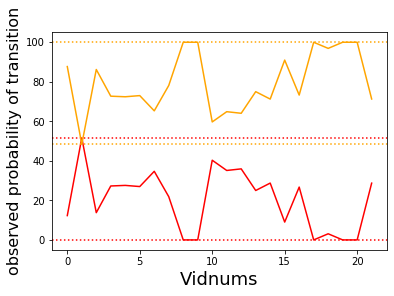

In [10]:

# Print probabilitie sby video
plotter(vidinds, vidsums.T, cols, 'Vidnums')


Get the observed probabilities, by stability threshold. This is the number of consecutive frames which must be registered as a state before the state changes. Any braak in the chain resets the counting. 

In [11]:
cprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items():
        c_thresh = c_threshes[expt][runnum] #Where the selection magic happens
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if c_thresh not in cprops.keys():
                cprops[c_thresh] = rundict[key]                
            else:
                cprops[c_thresh] = np.vstack((cprops[c_thresh], rundict[key]))
            #print("List of transition pairs for video {}: \n{}".format(key, vidprops[vidnumkey]))

#Got to double check!
keys = sorted(cprops.keys())
csums = [] #sum all the probabilities 
for key in keys:
    allprobs = cprops[key]
    print("Collected all arrays for c_threshold  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    csums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
csums = np.array(csums)
cinds = keys  
print("C_thresholds used:", cinds)
print("\nShape of total data array", np.shape(csums))




Collected all arrays for c_threshold  15.0: 
[[ 45.          55.        ]
 [ 42.85714286  57.14285714]
 [ 37.5         62.5       ]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 18.08510638  81.91489362]
 [ 29.05405405  70.94594595]
 [  0.         100.        ]
 [  6.25        93.75      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 27.20588235  72.79411765]
 [ 45.          55.        ]
 [ 40.          60.        ]
 [ 33.33333333  66.66666667]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 11.85185185  88.14814815]
 [ 21.21212121  78.78787879]
 [  0.         100.        ]
 [  7.14285714  92.85714286]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 29.74137931  70.25862069]
 [ 45.          55.        ]
 [  0.         100.        ]
 [ 33.33333333  66.66666667]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 12.63157895  87.36842105]
 [ 21.83908046  78.16091954]
 [  0.         100.        ]
 [  8.33333333  91.66666667

As you see, the proportions are not very sensitive to this. 

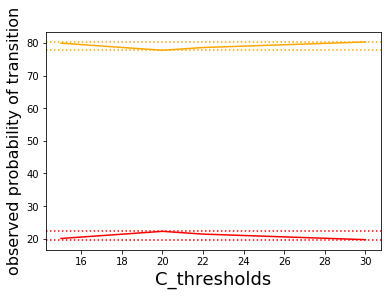

In [12]:
plotter(cinds, csums.T, cols, 'C_thresholds')

Get how the transition probabilities vary wrt the transition sthreshold; how many frames does a raft remain broken for before 
it is classified as broken. This only applies in the case of transitions to the same state as the original. 

In [13]:
tprops = {}

# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items():
        t_thresh = t_threshes[expt][runnum]
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if t_thresh not in tprops.keys():
                tprops[t_thresh] = rundict[key]                
            else:
                tprops[t_thresh] = np.vstack((tprops[t_thresh], rundict[key]))
            #print("List of transition pairs for video {}: \n{}".format(key, vidprops[vidnumkey]))

#Got to double check!
keys = sorted(tprops.keys())
tsums = [] #sum all the probabilities 
for key in keys:
    allprobs = tprops[key]
    print("Collected all arrays for T_threshold  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    tsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
tsums = np.array(tsums)
tinds = keys  
print("T_thresholds used:", tinds)
print("\nShape of total data array", np.shape(tsums))



Collected all arrays for T_threshold  30.0: 
[[  8.33333333  91.66666667]
 [ 50.6097561   49.3902439 ]
 [ 29.54545455  70.45454545]
 [  0.         100.        ]
 [ 44.44444444  55.55555556]
 [ 21.32352941  78.67647059]
 [ 30.65934066  69.34065934]
 [ 43.75        56.25      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 45.          55.        ]
 [ 42.85714286  57.14285714]
 [ 37.5         62.5       ]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 18.08510638  81.91489362]
 [ 29.05405405  70.94594595]
 [  0.         100.        ]
 [  6.25        93.75      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 27.20588235  72.79411765]
 [ 37.5         62.5       ]
 [ 43.75        56.25      ]
 [ 41.66666667  58.33333333]
 [ 25.          75.        ]
 [ 35.          65.        ]
 [ 11.42857143  88.57142857]
 [ 30.          70.        ]
 [  0.         100.        ]
 [  0.         100.        ]
 [  0.         100.        ]
 [  0.         100.        

Within the threshold range used, the probabilities are insensitive to this. 

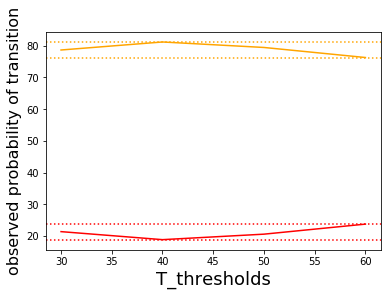

In [14]:
plotter(tinds, tsums.T, cols, 'T_thresholds')

One weakenss is an inability to recognize transitions that occur by unorthodox motions like sliding of one particle from the edge through the middle (which ahs been observed), if the final state isn't different than the original. 

This is a sun, for each pairt of thresholds, of the observed probailities of transition. 
Because only one run went to completion (one pair of thresholds), there is not a range for indices here, only a single 
value for each state's observed probability. 

In [29]:
rprops = {}
exptnum = 0
bignum = 100
# collect, for each video (in each run), the list of matrices recorded
for ind, expt in enumerate(stored_y_values.keys()):
    exptdicts = stored_y_values[expt]     
    for runnum, rundict in exptdicts.items(): 
        t_thresh = t_threshes[expt][runnum]
        c_thresh = c_threshes[expt][runnum]
        runkey = (t_thresh, c_thresh)
        keys = rundict.keys() # vifdeo number of run
        for key in keys: #evry video
            if runkey not in rprops.keys():
                rprops[runkey] = rundict[key]                
            else:
                rprops[runkey] = np.vstack((rprops[runkey], rundict[key]))
    exptnum += bignum

#Got to double check!
keys = sorted(rprops.keys())
rsums = [] #sum all the probabilities 
for key in keys:
    allprobs = rprops[key]
    print("Collected all arrays for run  {}: \n{}".format(key, allprobs))
    if len(np.shape(allprobs)) > 1:
        allprobs_sum = np.sum(allprobs, axis = 0) / len(allprobs)
    else:
        allprobs_sum = allprobs
    rsums.append(allprobs_sum )
    print("And summed and averaged all probabilities:\n{}\n".format(allprobs_sum))
rsums = np.array(rsums)
rinds = list(range(len(keys)))  
print("Runs done:",keys)
print("\nShape of total data array", np.shape(rsums))



Collected all arrays for run  (30.0, 15.0): 
[[ 45.          55.        ]
 [ 42.85714286  57.14285714]
 [ 37.5         62.5       ]
 [ 25.          75.        ]
 [ 33.33333333  66.66666667]
 [ 18.08510638  81.91489362]
 [ 29.05405405  70.94594595]
 [  0.         100.        ]
 [  6.25        93.75      ]
 [  0.         100.        ]
 [  0.         100.        ]
 [ 27.20588235  72.79411765]]
And summed and averaged all probabilities:
[22.02379325 77.97620675]

Collected all arrays for run  (30.0, 20.0): 
[[  8.33333333  91.66666667]
 [ 50.6097561   49.3902439 ]
 [ 29.54545455  70.45454545]
 [  0.         100.        ]
 [ 44.44444444  55.55555556]
 [ 21.32352941  78.67647059]
 [ 30.65934066  69.34065934]
 [ 43.75        56.25      ]
 [  0.         100.        ]
 [  0.         100.        ]]
And summed and averaged all probabilities:
[22.86658585 77.13341415]

Collected all arrays for run  (30.0, 22.0): 
[[ 37.5         62.5       ]
 [ 43.75        56.25      ]
 [ 41.66666667  58.33333333

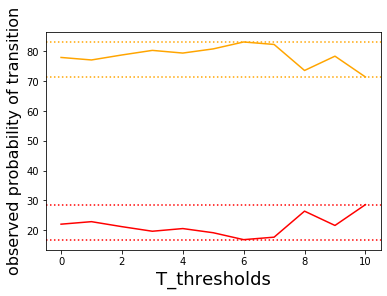

In [30]:
plotter(rinds, rsums.T, cols, 'T_thresholds') #max,min for each state

This graph shows what ransition probabilities we expect if the particles were to move along th eperimeter of thr raft, in a 'hinging' motion. The moving particle is on the long axis (as they have fewer contacts),
and it uses a neighbouring particle on the short ais as its hinge. For each state, the particles on either end of the long 
axis are allowed to move either clockwise or counterclockwise, with no bias in either direction. Bonds broken in order to move are not included. 
The bold lines show the expected probailities of transitioning to each state, with a given ratio of bond strength, where alpha represents the ratio of a styrene-ethylene bond over a styrene-styrene bond. The inverse of this is called the (relative) styrene bond strength. 
This probability the same as the proportion of transitions from the state, at steady state.

The dashed lines represent the observed probabilities of transitions. As there is no interesection between the dashed and bold lines, this model does not capture the data. 


alpha = 0.0

 [[0.   1.  ]
 [0.67 0.33]]

alpha = 0.05

 [[0.09 0.91]
 [0.66 0.34]]

alpha = 0.1

 [[0.15 0.85]
 [0.65 0.35]]

alpha = 0.15000000000000002

 [[0.21 0.79]
 [0.63 0.37]]

alpha = 0.2

 [[0.25 0.75]
 [0.62 0.37]]

alpha = 0.25

 [[0.29 0.71]
 [0.62 0.38]]

alpha = 0.30000000000000004

 [[0.32 0.68]
 [0.61 0.39]]

alpha = 0.35000000000000003

 [[0.34 0.66]
 [0.6  0.4 ]]

alpha = 0.4

 [[0.36 0.64]
 [0.59 0.41]]

alpha = 0.45

 [[0.38 0.62]
 [0.58 0.42]]

alpha = 0.5

 [[0.4  0.6 ]
 [0.57 0.43]]

alpha = 0.55

 [[0.42 0.58]
 [0.56 0.44]]

alpha = 0.6000000000000001

 [[0.43 0.57]
 [0.56 0.44]]

alpha = 0.65

 [[0.44 0.56]
 [0.55 0.45]]

alpha = 0.7000000000000001

 [[0.45 0.55]
 [0.54 0.46]]

alpha = 0.75

 [[0.46 0.54]
 [0.53 0.47]]

alpha = 0.8

 [[0.47 0.53]
 [0.53 0.47]]

alpha = 0.8500000000000001

 [[0.48 0.52]
 [0.52 0.48]]

alpha = 0.9

 [[0.49 0.51]
 [0.51 0.49]]

alpha = 0.9500000000000001

 [[0.49 0.51]
 [0.51 0.49]]

alpha = 1.0

 [[0.5 0.5]
 [0.5 0.5]]

alpha =

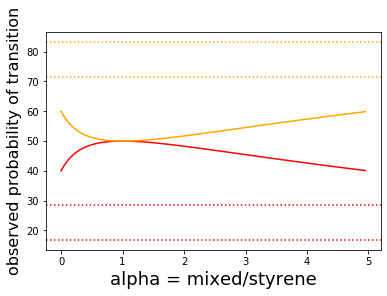

In [33]:
alphas = np.linspace(0, 5, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    print('\nalpha = %s' %i)
    T_expected_broad = np.asarray([[4*i, 2*(i + 1)],
     [4, 2*(i+1)]])
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    print('\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    x1.append(evec_one[0])
    x2.append(evec_one[1])
xs = np.vstack((x1, x2))
eig_plotter(alphas, xs, cols, 'alpha = mixed/styrene', rsums.T) #using rsum = runs for ranges

This is the same as before, but the bond formed (weighted by their strenghts) are divided by the bonds broken, which provides as cost to motion. 
In the 3-polystyren case, this does capture the data, indicated by both pairs of coloured lines crossing at about the same alpha value. 

This means tha the transition statistics we see are possible using only hinge mtion (although both types of motion do inf act occur). 

In other cases, such as some 3-polyethylene runs, it is not possible to reocver the statistics using only hinge mption. 




alpha = 0.0

 [[0.67 0.33]
 [0.67 0.33]]

alpha = 0.12

 [[0.64 0.36]
 [0.64 0.36]]

alpha = 0.24

 [[0.62 0.38]
 [0.62 0.38]]

alpha = 0.36

 [[0.6 0.4]
 [0.6 0.4]]

alpha = 0.48

 [[0.57 0.43]
 [0.57 0.43]]

alpha = 0.6

 [[0.56 0.44]
 [0.56 0.44]]

alpha = 0.72

 [[0.54 0.46]
 [0.54 0.46]]

alpha = 0.84

 [[0.52 0.48]
 [0.52 0.48]]

alpha = 0.96

 [[0.51 0.49]
 [0.51 0.49]]

alpha = 1.08

 [[0.49 0.51]
 [0.49 0.51]]

alpha = 1.2

 [[0.48 0.52]
 [0.48 0.52]]

alpha = 1.3199999999999998

 [[0.46 0.54]
 [0.46 0.54]]

alpha = 1.44

 [[0.45 0.55]
 [0.45 0.55]]

alpha = 1.56

 [[0.44 0.56]
 [0.44 0.56]]

alpha = 1.68

 [[0.43 0.57]
 [0.43 0.57]]

alpha = 1.7999999999999998

 [[0.42 0.58]
 [0.42 0.58]]

alpha = 1.92

 [[0.41 0.59]
 [0.41 0.59]]

alpha = 2.04

 [[0.4 0.6]
 [0.4 0.6]]

alpha = 2.16

 [[0.39 0.61]
 [0.39 0.61]]

alpha = 2.28

 [[0.38 0.62]
 [0.38 0.62]]

alpha = 2.4

 [[0.37 0.63]
 [0.37 0.63]]

alpha = 2.52

 [[0.36 0.64]
 [0.36 0.64]]

alpha = 2.6399999999999997

 [[0.35 0

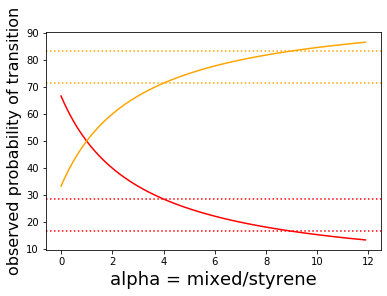

In [34]:
alphas = np.linspace(0, 12, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    print('\nalpha = %s' %i)
    T_expected_broad = np.asarray([[2, i + 1],
     [4/(i+1), 2]])
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    print('\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    x1.append(evec_one[0])
    x2.append(evec_one[1])
xs = np.vstack((x1, x2))
eig_plotter(alphas, xs, cols, 'alpha = mixed/styrene', rsums.T) #using rsum = runs for ranges


Breaking apart !!


 [[1. 0.]
 [1. 0.]]

 [[0.89 0.11]
 [0.89 0.11]]

 [[0.81 0.19]
 [0.81 0.19]]

 [[0.74 0.26]
 [0.74 0.26]]

 [[0.68 0.32]
 [0.68 0.32]]

 [[0.62 0.38]
 [0.62 0.38]]

 [[0.58 0.42]
 [0.58 0.42]]

 [[0.54 0.46]
 [0.54 0.46]]

 [[0.51 0.49]
 [0.51 0.49]]

 [[0.48 0.52]
 [0.48 0.52]]

 [[0.45 0.55]
 [0.45 0.55]]

 [[0.43 0.57]
 [0.43 0.57]]

 [[0.41 0.59]
 [0.41 0.59]]

 [[0.39 0.61]
 [0.39 0.61]]

 [[0.37 0.63]
 [0.37 0.63]]

 [[0.36 0.64]
 [0.36 0.64]]

 [[0.34 0.66]
 [0.34 0.66]]

 [[0.33 0.67]
 [0.33 0.67]]

 [[0.32 0.68]
 [0.32 0.68]]

 [[0.3 0.7]
 [0.3 0.7]]

 [[0.29 0.71]
 [0.29 0.71]]

 [[0.28 0.72]
 [0.28 0.72]]

 [[0.27 0.73]
 [0.27 0.73]]

 [[0.27 0.73]
 [0.27 0.73]]

 [[0.26 0.74]
 [0.26 0.74]]

 [[0.25 0.75]
 [0.25 0.75]]

 [[0.24 0.76]
 [0.24 0.76]]

 [[0.24 0.76]
 [0.24 0.76]]

 [[0.23 0.77]
 [0.23 0.77]]

 [[0.22 0.78]
 [0.22 0.78]]

 [[0.22 0.78]
 [0.22 0.78]]

 [[0.21 0.79]
 [0.21 0.79]]

 [[0.21 0.79]
 [0.21 0.79]]

 [[0.2 0.8]
 [0.2 0.8]]

 [[0.2 0.8]
 [0.2 0.8]]

 [[0

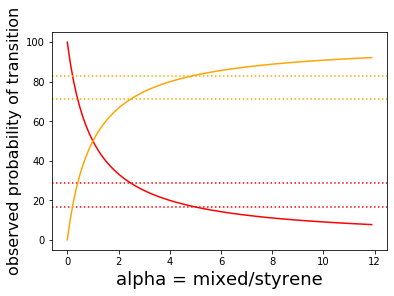

In [35]:
alphas = np.linspace(0, 12, 100,endpoint =False)
x1 = []
x2 = []
for i in alphas:
    t = (2/((1+i)*(2+2*i))+
         4*i/((1+i)*(2+2*i)*(4+2*i))+
          2*i/((1+i)*(4+2*i)))
    #print(bm)
    c = (2*i/((1+i)*(4+2*i))+
          i*(2+2*i)/((1+i)*(4+2*i)))
    
    T_expected_broad = np.asarray([[t, c],
     [t, c]])
    T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
    print('\n', np.around(T_expected_broad_norm, 2))
    eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
    eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
    eigvec_one = eigvecs[:, eig_one_index]
    evec_one = eigvec_one*100 / np.sum(eigvec_one)
    x1.append(evec_one[0])
    x2.append(evec_one[1])
xs = np.vstack((x1, x2))
eig_plotter(alphas, xs, cols, 'alpha = mixed/styrene', rsums.T) #using rsum = runs for ranges


The proportion of hinge motion varies probably with different runs, and there's not a way to know how much hinging vs breaking apart 
takes place, unless there is an independent onstraint on the bond strengths. 
This grpah shows the flexibility one has in modeling the transitiosn by chosing some linear combination of the break apart and hinging matrices. 

the far left of this graph shows the mixed bond / styrene-styrene bodn inferred if there was only breaking apart, and the far left shows for only hinging. 

In the event of the green line crossing the x axis, that is the largest proportion of hingin motion which could occur, and at this point it is as if the glass bond was infinitely larger than the mixed bond. 
Then, the data looks as isf the glass particles never moved, and the polystyrene particles moved freely around their perimeter 
when hinging takes place, and likewise that they're far mroe attractive during reassembl atter a break apart. 
This happens in some 3-polyethylene runs, when it's not possible to use more than [] percent hinging to explian the data. 

[(16.830792043750723, 28.571428571428573), (71.42857142857143, 83.16920795624928)]


Text(0.5, 0, 'proprtion of hinge motion')

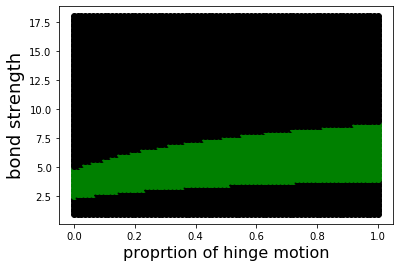

In [36]:
#narrow observations array
fig, ax = plt.subplots()
alphas = np.linspace(1, 10, 80)
ratios = np.linspace(0, 1, 80)
tolerances = [minmax(i) for i in rsums.T]
print("Acceptable ranges for top state, c-state proportions:", tolerances)


for i in alphas:
    for r in ratios:
        #print('\nalpha = %s' %i)
        #print(tm)
        t = (2/((1+i)*(2+2*i))+
         4*i/((1+i)*(2+2*i)*(4+2*i))+
          2*i/((1+i)*(4+2*i)))
        #print(bm)
        c = (2*i/((1+i)*(4+2*i))+
              i*(2+2*i)/((1+i)*(4+2*i)))

        T2 = np.asarray([[t, c],
         [t, c]])
        T1 = np.asarray([[2, i + 1],
         [4/(i+1), 2]])
        T_expected_narrow = r*T1 + (1-r)*T2
        #print(T_expected_narrow)
        T_expected_broad = T_expected_narrow
        T_expected_broad_norm = np.vstack([T_expected_broad[i]/np.sum(T_expected_broad[i]) for i in range(len(T_expected_broad))])
        #print(T_expected_broad_norm, '\n\n', np.around(T_expected_broad_norm, 2))
        eigvals, eigvecs = np.linalg.eig(T_expected_broad_norm.T)
        eig_one_index = [x for x in range(len(eigvals)) if math.isclose(eigvals[x], 1.0, abs_tol = .0001)][0]
        eigvec_one = eigvecs[:, eig_one_index]
        evec_one = eigvec_one*100 / np.sum(eigvec_one)
        #print("Eigenvector for eigenvalue 1 of T_ob_norm:")
        #print(evec_one)
        #plt.plot((i, i, i), (evec_one), 'x')
        test = all((evec_one[i]>= tolerances[i][0] and evec_one[i]<= tolerances[i][1])  for i in range(len(evec_one)))
        if test:
            col = "green"
        else:
            col = "k"
        plt.plot(r, i, c=col, marker='o')
plt.ylabel('bond strength', fontsize=18)
plt.xlabel('proprtion of hinge motion', fontsize=16)

Now to collect data on the ttransitions times, by run index. 

In [ ]:
# GEt regime of transitions
#parser_arr(glob('./timestotrans.txt')[0])

trans_runs= parser_arr(glob('./wash*styrene.txt')[0])
reduced_times = dict()
t_threshes = []
c_threshes = []    
index = list(range(len(trans_runs[0])))

vidnumset = []
print('\nlen indices', len(index))
for i in index:
    #xs_tr = []
    #xs_ti = []
    trans_matrices = []
    times_matrices = []
    N_transitions = trans_runs[0][i]
    #print(np.shape(trans_runs[2]))
    transarrs = np.array(trans_runs[2][i][0])
    timarrs = np.array(trans_runs[2][i][2]) ##########
    vidnums = trans_runs[2][i][1]
    print('vidnums', vidnums)
    allowed_inds = [x for x in range(len(vidnums)) if vidnums[x] not in excludedvids]
    print('disallowed numbers', excludedvids)
    print('disallowed indices', [x for x in range(len(vidnums)) if vidnums[x] in excludedvids])
    print('allowed indices', allowed_inds)
    vidnums = [vidnums[x] for x in allowed_inds]
    print('vidnums filtered', vidnums)
    transarrs = transarrs[allowed_inds]
    timarrs = timarrs[allowed_inds]
    #print(row_norm(vidarrs))
    #vidarrs = np.cumsum(vidarrs, axis=0)
    vidindices = list(range(len(transarrs)))
    #print(vidnums)
    for vidindex in vidindices: 
        Tr_obb = transarrs[vidindex]
        trans_matrices.append(Tr_obb)
        #print('Transitions ob', Tr_obb)
        Ti_obb = timarrs[vidindex] ##################
        times_matrices.append(Ti_obb)
        #print('Times ob', Ti_obb)
    #print("\nTransitions", trans_matrices)
    #print("\n\nTimes", times_matrices)
    t_threshes.append(trans_threshes[0])
    c_threshes.append(trans_threshes[1])
    

    
    #print(len(times_matrices), len(times_matrices[0]))
    #print(np.shape(times_matrices[0][0]))
    timestotrans = np.array(times_matrices)
    print('tt_shape', np.shape(timestotrans))
    #print(type(timestotrans))
    timestotrans = np.moveaxis(timestotrans, [0,1,2,3], [3, 0,1,2])
    print('tt_shape', np.shape(timestotrans))
    #print(timestotrans[0], '\n\n',type(timestotrans[0][0][0]), timestotrans[0][0][0], [x for y in timestotrans[0][0][0] for x in y])
    indices = np.shape(timestotrans)
    #print(len(indices))
    reduced_timestotrans = np.empty(indices[0:-2], dtype = object)
    #print(reduced_timestotrans)
    for m in range(indices[0]):
        time = timestotrans[m]
        for j in range(indices[1]):
            fromrow = time[j]
            collector = []
            for k in range(indices[2]):
                tocolumn = fromrow[k]
                #print("TOCOLUMN", tocolumn)
                tocolumn = np.array(flattener(tocolumn))
                #print("flattened", tocolumn)
                
                collector.extend(tocolumn)
            if collector ==[]: #if there's nothing in a ROW
                reduced_timestotrans[m,j]= collector# [np.nan] # set the from row
            else:
                reduced_timestotrans[m,j] = collector
            #print('timesrow',reduced_timestotrans[m,j] )
    #timestotrans = np.concatenate(timestotrans, axis=-1)
    print('SHAPE', np.shape(reduced_timestotrans))
    print('reduced', reduced_timestotrans[0])
    print('len of rows per time ', [[len(i) for i in x] for x in reduced_timestotrans])
    print(len([x for y in np.ravel(timestotrans) for x in y]), len([i for x in np.ravel(reduced_timestotrans) for i in x]))
    reduced_times[i] = reduced_timestotrans
    #reduced_timestotrans = per time, pper origin, list of transitions times
    


From the means and variance of the stability times, one can see that the states are on average stbale for the same lenghts of time,
but that there is more variance with the c-state, which also has a relatively huge bias towards short er times as well as some rare long ones. 

Disregarding the long ones, which are infrequeny, the c-shape

In [ ]:
import seaborn 
labels = ["Top", "C-shape"]

def binnerseq(seq, nbins, discardfrac):
    maximum = np.nanmax([x for y in seq for x in y])
    print('MAX', maximum)
    rang = maximum
    bins = list(np.linspace(0, np.round(maximum/discardfrac), nbins-1))
    #bins.append(maximum) 
    print('BINS', bins)
    return np.array(bins)



    

for i in index[0:1]:   
    trans_threshes = trans_runs[1][i] 
    total_time = (reduced_times[i])[0]
    stable_time= (reduced_times[i])[1]
    unstable_time= (reduced_times)[i][2]
    #print(stable_time.T)
    # for each time, separate the three axes
    times = [total_time, stable_time, unstable_time]
    print("Times: ")
    for i in times:
        print('means, ',[np.round(np.nanmean(x)) for x in i])        
        print('vaars, ',[np.round(np.nanvar(x)) for x in i])
        print(i, '\n')
    timenames = ["Frames between transitions", "Frames stable", "Frames unstable"]
    time = times[1]
    timename = timenames[1]
    #times, timenames = times[1:2], timenames[1:2]
    
    
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))   
    ax.set_prop_cycle(color=cols)
    print(time)
    #
    #time = [time[0]]
    ax.hist(time, bins=binnerseq(time,  60, 1))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    fig, ax = plt.subplots(figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))   
    ax.set_prop_cycle(color=cols)
    ax.hist(time, bins=binnerseq(time,  60, 6))######
    ax.set_xlabel(timename)
    ax.set_ylabel("Number of videos")
    ax.legend(labels)
    
    
    fig, ax = plt.subplots( figsize = (14, 10))
    fig.suptitle("Run no." + str(trans_threshes[0]) + "," + str(trans_threshes[1]))  
    ax.set_prop_cycle(color=cols)
    ax.boxplot(time, labels = labels)####
    ax.set_ylabel(timenames)
    ax.set_xlabel("Type of shape")
    ax.legend(labels)

The transition times are heavily biased towards short times of stability for the c-shape, which is the most observed. This state has frequent transitions to na dfrom, 
and it is in a sense most favoured since ti s most visited, but it is less stable also, as the visits are brief. 
In contrat, the top state, which is rarely observed,  is stable for all lengths of time equally. 

I think this is just a byproduct of the frequency of transitions; the c state has more short-lived periods because it 
has more periods overall. 



Or, that there is an attractor in that, once you leve as tate, it is most easy to return to it, so the more times one 
spends in a state the mroe one attracts brief semi-transitions where a particle attempts t leave and the ncomes back. 


Really, 
the reasont huis happens is becuas e when these particles breal away they're really energetic, and it takes multiple hops to release all fo that energy. this measn there are a lost of break aparats probably, within a short interval, and this interval lenghtens as the reaft calms dow. this matches observations, by th eway. And the reate of decay is then exponential, for the energy. The same thing is happening probably to 'transitions'within state, which are not 'real'transitions, but fluctuations of a raft where it breaks apart but not far enough to let each particle go freely away, and they all fall down. The distance outward they go and the number fo times this repeats will dpeend on th eenergy the raft has, and I cna see short frequent burst beng a comon occurence, which would cause lots of fhosrt lived state records being made. 

The other reason fro such short stability times is that it is clear from the very low counts that some states are underrecorded, i.e. that jsut the tai lend of the statss lifetime is recorded. This explains the extremly high incidence of small times but it is a effect that shoud taper off and has it's own curve that's probably not an exponential decay, s it desn't explain that part (the self similarity, ie tha all the later brakcets looks like this). It means that these historgrams are onyl for the transitions from the very most stable states and a lot fo faster state pass-throughs are beign missed. They can be caught with a lower threshold.. 

To clarify, lots of lowe thresholds need to be sampled to get the erro and make sure that at low stbailti yT's, the dats is not ebing swamped by noise from the fluctuatin gclassificaion error, which is also a thing. 
